# CELL 1 - Initialization

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import optuna
import random
import kagglehub # Import for the new download method

# --- Constants and Setup ---

IMAGE_SIZE = 100 
BATCH_SIZE = 64
RANDOM_SEED = 42
NUM_EPOCHS_TUNE = 5 # Fewer epochs for quick HPO search
NUM_EPOCHS_FINAL = 50 # Max epochs for final training (with Early Stopping)

# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Determine device (CUDA for GPU training)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")


# --- Kaggle Download and DATA_DIR Setup ---
DATASET_ID = "utkarshsaxenadn/fruits-classification"

print(f"\nDownloading Kaggle dataset ID: {DATASET_ID} using kagglehub...")
print("NOTE: This requires your Kaggle API key (kaggle.json) to be set up in ~/.kaggle/.")

try:
    # Use kagglehub to download the dataset
    path = kagglehub.dataset_download(DATASET_ID)
    
    # kagglehub returns the path to the root of the extracted dataset files
    DATA_DIR = str(path)
    
    print("Download complete.")
    print(f"Path to dataset files: {DATA_DIR}")
    
except Exception as e:
    print(f"Kaggle Download Failed. Error: {e}")
    print("Please ensure your Kaggle API key is correctly configured and the kernel is switched.")
    # Fallback path if the download fails for manual placement
    DATA_DIR = './fruits-classification' 
    print(f"Falling back to assumed manual data path: {DATA_DIR}")

Using device: cuda
CUDA device name: NVIDIA GeForce RTX 3060

NOTE: This requires your Kaggle API key (kaggle.json) to be set up in ~/.kaggle/.
Download complete.
Path to dataset files: C:\Users\Bence\.cache\kagglehub\datasets\utkarshsaxenadn\fruits-classification\versions\1


# CELL 2 - Preprocessing

In [2]:
# --- Data Transforms, Normalization, and Features (Data Augmentation) ---

# 1. PIL Image Transforms (Augmentation applied before Tensor conversion)
pil_transforms = [
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
]

# 2. Tensor Conversion
tensor_conversion = [
    transforms.ToTensor(),
]

# 3. Tensor Transforms (Augmentation and Normalization applied after Tensor conversion)
tensor_transforms = [
    # FIX: RandomErasing MUST be after ToTensor()
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)), 
    # Normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
]

# Training Transforms (All steps)
train_transforms = transforms.Compose(pil_transforms + tensor_conversion + tensor_transforms)

# Validation/Test Transforms (Only resize, ToTensor, Normalization)
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


# --- Adatfolyam (ImageFolder és DataLoader) ---
TRAIN_DIR = DATA_DIR + '\\Fruits Classification\\train'
TEST_DIR = DATA_DIR + '\\Fruits Classification\\test'

train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_data = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

# Split training data into training and validation sets (80/20 split)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_data, [train_size, val_size])

# Create DataLoaders (Data Streaming)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

CLASS_NAMES = train_data.classes
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of Classes: {NUM_CLASSES}")

Number of Classes: 5


# CELL 3 - CNN Model Buildup

In [3]:
class FruitCNN(nn.Module):
    def __init__(self, num_conv_layers, filters, dense_units, dropout_rate, num_classes):
        super(FruitCNN, self).__init__()

        layers = []
        in_channels = 3
        current_img_size = IMAGE_SIZE

        # --- Create Exactly 'num_conv_layers' (7) ---
        for i in range(num_conv_layers):
            out_channels = filters * (2**i)
            # Cap filters to 512 to prevent memory explosion
            if out_channels > 512: out_channels = 512

            # 1. Convolution + Activation (Always add these)
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU()
            ]

            # 2. Conditional Pooling (Only pool if image is large enough)
            # We need at least 2x2 pixels to pool. We use a buffer of 4.
            if current_img_size > 4:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                current_img_size //= 2  # Track size reduction

            in_channels = out_channels

        self.features = nn.Sequential(*layers)

        # Calculate flatten size dynamically
        # This prevents the "size mismatch" error at the Linear layer
        with torch.no_grad():
            dummy = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE)
            feature_map = self.features(dummy)
            flattened_size = feature_map.view(1, -1).size(1)

        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(flattened_size, dense_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dense_units, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# CELL 4 - Hyperparameter optimization

In [4]:
# --- Trainer Function for Optuna (One Epoch) ---
def train_one_epoch_optuna(model, train_loader, optimizer, criterion, device):
    """Trains the model for one epoch."""
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# --- Evaluator Function for Optuna ---
def evaluate_model_optuna(model, val_loader, device):
    """Evaluates the model on validation data."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# --- Optuna Objective Function ---
def objective(trial):
    # --- Hyperparameters ---
    # FIXED: Constraint set to exactly 7 layers as requested
    hp_num_conv_layers = 7

    # Search space for other parameters
    hp_filters = trial.suggest_categorical('filters', [64, 128, 256]) # Start smaller to save RAM
    hp_dense_units = trial.suggest_categorical('dense_units', [256, 512, 1024])
    hp_dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.3, step=0.1)

    # FIXED: Replaced deprecated suggest_loguniform with suggest_float(log=True)
    hp_learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)

    print(f"\n--- Trial {trial.number} ---")
    print(f"Params: Layers={hp_num_conv_layers}, Filters={hp_filters}, LR={hp_learning_rate:.6f}")

    # --- Model Setup ---
    model = FruitCNN(
        num_conv_layers=hp_num_conv_layers,
        filters=hp_filters,
        dense_units=hp_dense_units,
        dropout_rate=hp_dropout_rate,
        num_classes=NUM_CLASSES # Ensure this is defined in your global scope
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hp_learning_rate)

    # --- Training Loop ---
    for epoch in range(NUM_EPOCHS_TUNE):
        # Using your existing train/eval functions
        train_loss = train_one_epoch_optuna(model, train_loader, optimizer, criterion, DEVICE)
        accuracy = evaluate_model_optuna(model, val_loader, DEVICE)

        # Report & Prune
        trial.report(accuracy, epoch)
        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch+1}")
            raise optuna.exceptions.TrialPruned()

    return accuracy

# --- Run Optuna Search ---
print("Starting Hyperparameter Optimization (HPO) with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("\n--- Best Trial Results ---")
best_trial = study.best_trial
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Retrieve best hyperparameters
best_hps = best_trial.params

[I 2025-12-12 19:48:46,197] A new study created in memory with name: no-name-b389c41a-d62e-4697-bdba-cf7f1b76116a


Starting Hyperparameter Optimization (HPO) with Optuna...

--- Trial 0 ---
Params: Layers=7, Filters=128, LR=0.000012


[I 2025-12-12 19:51:36,503] Trial 0 finished with value: 0.44536082474226807 and parameters: {'filters': 128, 'dense_units': 1024, 'dropout_rate': 0.2, 'learning_rate': 1.1958027027748749e-05}. Best is trial 0 with value: 0.44536082474226807.



--- Trial 1 ---
Params: Layers=7, Filters=64, LR=0.000382


[I 2025-12-12 19:54:08,877] Trial 1 finished with value: 0.5257731958762887 and parameters: {'filters': 64, 'dense_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.000381747315060502}. Best is trial 1 with value: 0.5257731958762887.



--- Trial 2 ---
Params: Layers=7, Filters=256, LR=0.000026


[I 2025-12-12 19:58:56,074] Trial 2 finished with value: 0.5015463917525773 and parameters: {'filters': 256, 'dense_units': 1024, 'dropout_rate': 0.3, 'learning_rate': 2.5936485653228404e-05}. Best is trial 1 with value: 0.5257731958762887.



--- Trial 3 ---
Params: Layers=7, Filters=64, LR=0.000447


[I 2025-12-12 20:01:01,034] Trial 3 finished with value: 0.493298969072165 and parameters: {'filters': 64, 'dense_units': 512, 'dropout_rate': 0.3, 'learning_rate': 0.0004465236510432301}. Best is trial 1 with value: 0.5257731958762887.



--- Trial 4 ---
Params: Layers=7, Filters=128, LR=0.000943


[I 2025-12-12 20:03:35,872] Trial 4 finished with value: 0.3556701030927835 and parameters: {'filters': 128, 'dense_units': 512, 'dropout_rate': 0.3, 'learning_rate': 0.000943493060284847}. Best is trial 1 with value: 0.5257731958762887.



--- Trial 5 ---
Params: Layers=7, Filters=64, LR=0.000089


[I 2025-12-12 20:05:37,935] Trial 5 finished with value: 0.5005154639175258 and parameters: {'filters': 64, 'dense_units': 1024, 'dropout_rate': 0.2, 'learning_rate': 8.918482490664636e-05}. Best is trial 1 with value: 0.5257731958762887.



--- Trial 6 ---
Params: Layers=7, Filters=256, LR=0.000088


[I 2025-12-12 20:09:17,645] Trial 6 finished with value: 0.5231958762886598 and parameters: {'filters': 256, 'dense_units': 512, 'dropout_rate': 0.2, 'learning_rate': 8.812318834477536e-05}. Best is trial 1 with value: 0.5257731958762887.



--- Trial 7 ---
Params: Layers=7, Filters=256, LR=0.000059


[I 2025-12-12 20:12:57,365] Trial 7 finished with value: 0.5123711340206185 and parameters: {'filters': 256, 'dense_units': 512, 'dropout_rate': 0.3, 'learning_rate': 5.9434640385816356e-05}. Best is trial 1 with value: 0.5257731958762887.



--- Trial 8 ---
Params: Layers=7, Filters=256, LR=0.000384


[I 2025-12-12 20:13:41,490] Trial 8 pruned. 


Trial 8 pruned at epoch 1

--- Trial 9 ---
Params: Layers=7, Filters=128, LR=0.000090


[I 2025-12-12 20:16:13,505] Trial 9 finished with value: 0.5077319587628866 and parameters: {'filters': 128, 'dense_units': 256, 'dropout_rate': 0.3, 'learning_rate': 8.97467860845594e-05}. Best is trial 1 with value: 0.5257731958762887.



--- Best Trial Results ---
Best Validation Accuracy: 0.5258
Best Hyperparameters:
  filters: 64
  dense_units: 256
  dropout_rate: 0.2
  learning_rate: 0.000381747315060502


# CELL 5 - Training, Testing, Validation and Final Evaluation

In [6]:
# --- Final Model Initialization ---
final_model = FruitCNN(
    num_conv_layers=7,
    filters=best_hps['filters'],
    dense_units=best_hps['dense_units'],
    dropout_rate=best_hps['dropout_rate'],
    num_classes=NUM_CLASSES
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=1e-2) #best_hps['learning_rate']

# --- Custom Early Stopping Logic (Low-Level Logic) ---
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device, patience=10):
    
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None
    
    print("Starting Final Training with Early Stopping...")
    
    for epoch in range(1, epochs + 1):
        # Training Phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            # FIX: labels already contains the class indices
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation Phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                # FIX: labels already contains the class indices
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total
        
        # Log History
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f'Epoch {epoch}/{epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        
        # Early Stopping Logic 
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best weights
            best_model_weights = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping at epoch {epoch}. Validation loss did not improve for {patience} epochs.")
                # Restore best weights
                model.load_state_dict(best_model_weights)
                break

    return model, history

# --- Run Final Training ---
final_model, history = train_and_validate(
    final_model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    NUM_EPOCHS_FINAL, 
    DEVICE
)

Starting Final Training with Early Stopping...
Epoch 1/50: Train Loss: 491.7433, Val Loss: 1.6091, Val Acc: 0.2062
Epoch 2/50: Train Loss: 1.6102, Val Loss: 1.6098, Val Acc: 0.2082
Epoch 3/50: Train Loss: 1.6103, Val Loss: 1.6105, Val Acc: 0.1912
Epoch 4/50: Train Loss: 1.6100, Val Loss: 1.6095, Val Acc: 0.1979
Epoch 5/50: Train Loss: 1.6104, Val Loss: 1.6100, Val Acc: 0.1964
Epoch 6/50: Train Loss: 1.6103, Val Loss: 1.6094, Val Acc: 0.2062
Epoch 7/50: Train Loss: 1.6102, Val Loss: 1.6091, Val Acc: 0.2082
Epoch 8/50: Train Loss: 1.6103, Val Loss: 1.6094, Val Acc: 0.1912
Epoch 9/50: Train Loss: 1.6098, Val Loss: 1.6107, Val Acc: 0.2082
Epoch 10/50: Train Loss: 1.6100, Val Loss: 1.6113, Val Acc: 0.1979
Epoch 11/50: Train Loss: 1.6102, Val Loss: 1.6095, Val Acc: 0.2062
Early stopping at epoch 11. Validation loss did not improve for 10 epochs.


# CELL 6 - Visualization


Overall Test Accuracy Score: 20.00%

--- Classification Report ---
              precision    recall  f1-score   support

       Apple     0.0000    0.0000    0.0000        20
      Banana     0.0000    0.0000    0.0000        20
       Grape     0.0000    0.0000    0.0000        20
       Mango     0.0000    0.0000    0.0000        20
  Strawberry     0.2000    1.0000    0.3333        20

    accuracy                         0.2000       100
   macro avg     0.0400    0.2000    0.0667       100
weighted avg     0.0400    0.2000    0.0667       100


--- Confusion Matrix ---


C:\mscmlbead\fruit_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\mscmlbead\fruit_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\mscmlbead\fruit_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


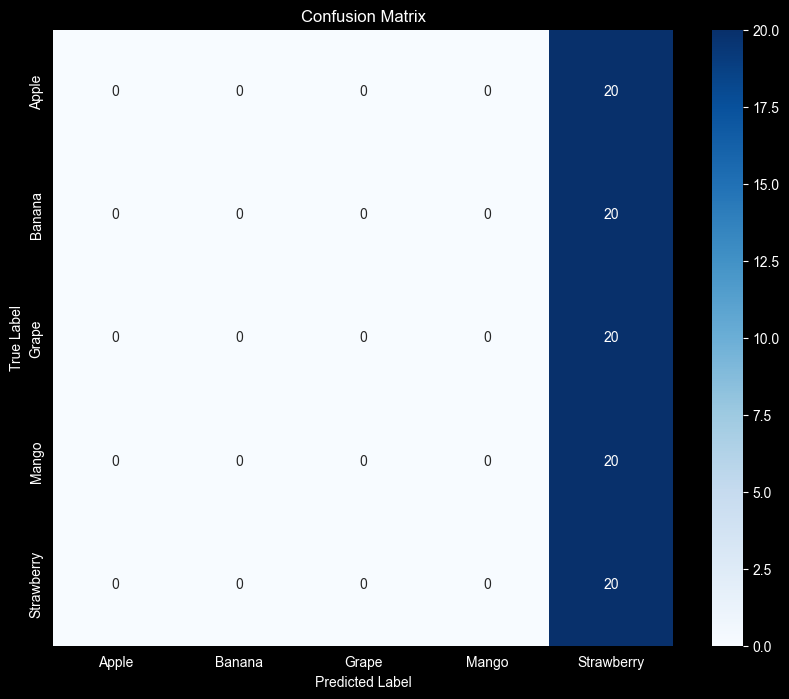

In [8]:
# --- Model Evaluation on Test Set ---
def evaluate_test(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # FIXED: Removed .argmax(dim=1) because labels are already indices
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate Overall Accuracy Score
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Test Accuracy Score: {overall_accuracy*100:.2f}%")

    # Classification Report (F-Score, Recall, Precision)
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion Matrix (Visualization)
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return overall_accuracy

# --- Run Test Evaluation ---
# Ensure your class_names list matches the number of classes in the model
test_accuracy = evaluate_test(final_model, test_loader, DEVICE, CLASS_NAMES)